In [1]:
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

ABS_PATH = os.getcwd()
awards_df =pd.read_csv(ABS_PATH+'/data/the_oscar_award.csv')
movies_df = pd.read_csv(ABS_PATH+'/data/movie_data.csv')

Steps to Calculate Star Power Index
	1.	Data Preparation:
	•	Clean and preprocess the movie dataset to calculate metrics like average IMDb score and user votes for each actor.
	•	Integrate the awards data to count nominations and wins for each actor.
	2.	Metrics for Star Power:
	•	Average IMDb Rating: Compute the average IMDb rating for movies in which the actor appeared.
	•	Awards Metrics: Count nominations and wins using the awards CSV.
	•	Longevity: Calculate the number of unique years an actor has movies in the dataset.
	•	Consistency: Standard deviation or variance of IMDb scores across an actor’s movies (lower variance reflects consistency).
	3.	Star Power Index:
	•	Combine all the metrics into a weighted score. For example:


$ \text{Star Power Index} = w_1 \times \text{Avg IMDb Score} + w_2 \times \text{Awards Score} + w_3 \times \text{Longevity} + w_4 \times \text{Consistency} $


	•	Normalize the metrics to ensure fair contribution to the index.
	4.	Deliverables:
	•	Star Power Index: A ranked list of actors based on the index.
	•	Visualization: Bar charts or heatmaps showing the contributions of individual metrics to the index.

HERE I STILL DIDNT DO A PLOT

In [2]:
# Load awards data into DataFrame
awards = awards_df
movies = movies_df

# Star Power Calculation
def calculate_star_power(movie_data, awards_data):
    # Preprocess the movies data
    actor_columns = ['actor_1_name', 'actor_2_name', 'actor_3_name']
    actor_movies = pd.melt(movie_data, id_vars=['movie_title', 'imdb_score', 'title_year'], 
                           value_vars=actor_columns, value_name='actor').dropna()

    # Average IMDb rating per actor
    actor_ratings = actor_movies.groupby('actor')['imdb_score'].mean().reset_index()
    actor_ratings.rename(columns={'imdb_score': 'avg_imdb_score'}, inplace=True)

    # Longevity (unique years)
    actor_longevity = actor_movies.groupby('actor')['title_year'].nunique().reset_index()
    actor_longevity.rename(columns={'title_year': 'longevity'}, inplace=True)

    # Consistency (standard deviation of IMDb scores)
    actor_consistency = actor_movies.groupby('actor')['imdb_score'].std().reset_index()
    actor_consistency.rename(columns={'imdb_score': 'consistency'}, inplace=True)

    # Merge actor metrics
    actor_metrics = actor_ratings.merge(actor_longevity, on='actor', how='left') \
                                 .merge(actor_consistency, on='actor', how='left')

    # Process awards data
    awards_count = awards_data.groupby('name').agg(
        nominations=('winner', 'count'),
        wins=('winner', 'sum')
    ).reset_index()
    awards_count.rename(columns={'name': 'actor'}, inplace=True)

    # Merge awards with actor metrics
    star_power_df = actor_metrics.merge(awards_count, on='actor', how='left').fillna(0)

    # Calculate Star Power Index
    star_power_df['star_power_index'] = (
        0.4 * star_power_df['avg_imdb_score'] +
        0.3 * star_power_df['wins'] +
        0.2 * star_power_df['longevity'] +
        0.1 * (1 / (1 + star_power_df['consistency']))
    )

    return star_power_df.sort_values('star_power_index', ascending=False)

# Calculate Star Power Index
star_power_df = calculate_star_power(movies, awards)

# Display the top actors based on Star Power Index
print(star_power_df[['actor', 'star_power_index']].head(10))

                   actor  star_power_index
4914      Robert De Niro          9.544134
2175       Harrison Ford          8.078749
4209      Morgan Freeman          7.925011
5725          Tom Cruise          7.865203
674            Brad Pitt          7.802226
1474   Denzel Washington          7.709261
5734           Tom Hanks          7.617085
388      Anthony Hopkins          7.597885
5520  Sylvester Stallone          7.374420
2901         Johnny Depp          7.347770


### the next histograms can be grouped en fonction de ce qu'on veut mettre ensemble, feel free to tell me lesquels vont les uns avec les autres et je changerai en fonction

In [ ]:
from ipywidgets import widgets
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd

# Analyze years with the most or fewest awards
awards_per_year = awards_df.groupby('year_ceremony').size()

# Study consistently nominated movies or individuals
nominations_per_film = awards_df.groupby('film').size().sort_values(ascending=False).head(10)
nominations_per_person = awards_df.groupby('name').size().sort_values(ascending=False).head(10)

# Filter nominations to include actors/actresses and others
actor_nominations = awards_df[awards_df['category'].str.contains('ACTOR|ACTRESS', case=False, na=False)]
non_actor_nominations = awards_df[~awards_df['category'].str.contains('ACTOR|ACTRESS', case=False, na=False)]

# Group by name and count nominations
nominations_per_actor = actor_nominations.groupby('name').size().sort_values(ascending=False).head(10)
nominations_per_non_actor = non_actor_nominations.groupby('name').size().sort_values(ascending=False).head(10)

# Create a dropdown widget for selecting filter type
filter_type = widgets.Dropdown(
    options=['Actors', 'Non-Actors'],
    value='Actors',
    description='Filter by:',
    disabled=False,
)

# Function to update the plot based on the selected filter
def update_plot(filter_type):
    if filter_type == 'Actors':
        data = nominations_per_actor
        title = 'Top 10 Most-Nominated Actors'
    else:
        data = nominations_per_non_actor
        title = 'Top 10 Most-Nominated Non-Actors'
    
    if data.empty:  # Check if the data is empty
        print(f"No data available for {filter_type}.")
        return
    
    plt.figure(figsize=(12, 8))
    data.plot(kind='bar', color='lightblue')
    plt.title(title, fontsize=16)
    plt.xlabel('Name', fontsize=14)
    plt.ylabel('Number of Nominations', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Interactive plot with dropdown
interactive_plot = widgets.interactive(update_plot, filter_type=filter_type)
display(interactive_plot)


interactive(children=(Dropdown(description='Filter by:', options=('Actors', 'Non-Actors'), value='Actors'), Ou…

some alternative filtering for the same plot

In [ ]:
from ipywidgets import widgets
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd

# Assume awards_df is already defined and loaded
# Example: awards_df = pd.read_csv('awards_data.csv')

# Compute the average nominations per category
average_nominations_per_category = awards_df.groupby('category').size().reset_index(name='nomination_count')
filtered_categories = (
    average_nominations_per_category
    .sort_values(by='nomination_count', ascending=False)
    .head(20)
    ['category']
)

# Create a dropdown widget for selecting filter type
filter_type = widgets.Dropdown(
    options=filtered_categories.tolist(),  # Use only filtered categories
    value=filtered_categories.iloc[0] if not filtered_categories.empty else None,  # Default to first filtered category
    description='Filter by:',
    disabled=False,
)

# Function to update the plot based on the selected filter
def update_plot(filter_type):
    if filter_type is None:
        print("No categories meet the criteria of average nominations > 4.")
        return
    
    filtered_nominations = awards_df[awards_df['category'] == filter_type]
    nominations_per_name = filtered_nominations.groupby('name').size().sort_values(ascending=False).head(10)
    
    if nominations_per_name.empty:  # Check if the data is empty
        print(f"No data available for category: {filter_type}.")
        return
    
    plt.figure(figsize=(12, 8))
    nominations_per_name.plot(kind='bar', color='lightblue')
    plt.title(f"Top 10 Most-Nominated in Category: {filter_type}", fontsize=16)
    plt.xlabel('Name', fontsize=14)
    plt.ylabel('Number of Nominations', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Interactive plot with dropdown
interactive_plot = widgets.interactive(update_plot, filter_type=filter_type)
display(interactive_plot)

interactive(children=(Dropdown(description='Filter by:', options=('DIRECTING', 'FILM EDITING', 'ACTOR IN A SUP…

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display

# Load the dataset
movies_df = pd.read_csv(ABS_PATH + '/data/movie_data.csv')  # Movies dataset

# Prepare data for actors
actor_columns = ['actor_1_name', 'actor_2_name', 'actor_3_name']
actors_df = movies_df[actor_columns].melt(value_name='actor').dropna(subset=['actor'])
top_actors = actors_df['actor'].value_counts().head(10)

# Prepare data for directors
top_directors = movies_df['director_name'].value_counts().head(10)

# Visualization function
def update_plot(view_option):
    if view_option == 'Top Actors':
        plt.figure(figsize=(12, 8))
        top_actors.plot(kind='bar', color='skyblue')
        plt.title('Top 10 Most Prolific Actors by Number of Movies', fontsize=16)
        plt.xlabel('Actor', fontsize=14)
        plt.ylabel('Number of Movies', fontsize=14)
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()
    elif view_option == 'Top Directors':
        plt.figure(figsize=(12, 8))
        top_directors.plot(kind='bar', color='lightgreen')
        plt.title('Top 10 Most Prolific Directors by Number of Movies', fontsize=16)
        plt.xlabel('Director', fontsize=14)
        plt.ylabel('Number of Movies', fontsize=14)
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

# Dropdown menu for switching views
view_dropdown = widgets.Dropdown(
    options=['Top Actors', 'Top Directors'],
    value='Top Actors',
    description='View:',
)

# Interactive plot display
interactive_plot = widgets.interactive(update_plot, view_option=view_dropdown)
display(interactive_plot)

interactive(children=(Dropdown(description='View:', options=('Top Actors', 'Top Directors'), value='Top Actors…

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display

# Load the dataset
movies_df = pd.read_csv(ABS_PATH + '/data/movie_data.csv')  # Movies dataset

# Prepare data for actors
actor_columns = ['actor_1_name', 'actor_2_name', 'actor_3_name']
actors_df = movies_df.melt(
    id_vars=['imdb_score'], value_vars=actor_columns, value_name='actor'
).dropna(subset=['actor'])

# Filter actors with at least 20 movies
actor_movie_counts = actors_df['actor'].value_counts()
eligible_actors = actor_movie_counts[actor_movie_counts >= 20].index
filtered_actors_df = actors_df[actors_df['actor'].isin(eligible_actors)]

# Calculate average IMDb scores for eligible actors
actors_avg_score = filtered_actors_df.groupby('actor')['imdb_score'].mean().sort_values(ascending=False).head(10)

# Prepare data for directors
director_movie_counts = movies_df['director_name'].value_counts()
eligible_directors = director_movie_counts[director_movie_counts >= 5].index
filtered_movies_df = movies_df[movies_df['director_name'].isin(eligible_directors)]

# Calculate average IMDb scores for eligible directors
directors_avg_score = filtered_movies_df.groupby('director_name')['imdb_score'].mean().sort_values(ascending=False).head(10)

# Visualization function
def update_plot(view_option):
    if view_option == 'Top Actors':
        plt.figure(figsize=(12, 8))
        actors_avg_score.plot(kind='bar', color='coral')
        plt.title('Top 10 Actors by Average IMDb Score (Actors with 20+ Movies)', fontsize=16)
        plt.xlabel('Actor', fontsize=14)
        plt.ylabel('Average IMDb Score', fontsize=14)
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()
    elif view_option == 'Top Directors':
        plt.figure(figsize=(12, 8))
        directors_avg_score.plot(kind='bar', color='orange')
        plt.title('Top 10 Directors by Average IMDb Score (Directors with 5+ Movies)', fontsize=16)
        plt.xlabel('Director', fontsize=14)
        plt.ylabel('Average IMDb Score', fontsize=14)
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

# Dropdown menu for switching views
view_dropdown = widgets.Dropdown(
    options=['Top Actors', 'Top Directors'],
    value='Top Actors',
    description='View:',
)

# Interactive plot display
interactive_plot = widgets.interactive(update_plot, view_option=view_dropdown)
display(interactive_plot)

interactive(children=(Dropdown(description='View:', options=('Top Actors', 'Top Directors'), value='Top Actors…

#### FROM RESULTS.IPYNB

In [21]:
character_metadata = pd.read_csv(ABS_PATH+'/data/CMU_dataset/character.metadata.tsv', sep='\t')
movie_metadata = pd.read_csv(ABS_PATH+'/data/CMU_dataset/movie.metadata.tsv', sep='\t')
oscar_data =pd.read_csv(ABS_PATH+'/data/the_oscar_award.csv')
movie_data = pd.read_csv(ABS_PATH+'/data/movie_data.csv')

In [22]:
movie_metadata.columns =['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date',
                        'Movie box office revenue','Movie runtime','Movie languages',
                        'Movie countries','Movie genres']
character_metadata.columns = [
    'Wikipedia movie ID',
    'Freebase movie ID',
    'Movie release date',
    'Character name',
    'Actor date of birth',
    'Actor gender',
    'Actor height (in meters)',
    'Actor ethnicity (Freebase ID)',
    'Actor name',
    'Actor age at movie release',
    'Freebase character/actor map ID',
    'Freebase character ID',
    'Freebase actor ID'
]

In [23]:
merged_movie_character = pd.merge(character_metadata, movie_metadata, 
                                  left_on='Wikipedia movie ID', 
                                  right_on='Wikipedia movie ID', 
                                  how='inner')
merged_movie_character.drop(columns=['Movie languages','Movie countries',
                                    'Freebase character/actor map ID','Freebase character ID','Freebase actor ID',
                                    'Freebase movie ID_y','Freebase movie ID_x'])

,Wikipedia movie ID,Movie release date_x,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Movie name,Movie release date_y,Movie box office revenue,Movie runtime,Movie genres
0,3196793,2000-02-16,Police Officer,NaN,M,NaN,NaN,Allen Cutler,NaN,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
1,3196793,2000-02-16,Reporter,1956-12-19,F,NaN,NaN,Alice Barrett,43.0,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,3196793,2000-02-16,NaN,NaN,M,NaN,NaN,Rod Britt,NaN,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
3,3196793,2000-02-16,NaN,NaN,F,NaN,NaN,Hildy Brooks,NaN,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
4,3196793,2000-02-16,FBI Profiler Robert Hanks,1950-01-05,M,NaN,NaN,Robert Catrini,50.0,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450647,913762,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."
450648,913762,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."
450649,28308153,1957,NaN,1941-11-18,M,1.73,/m/02w7gg,David Hemmings,15.0,Five Clues to Fortune,1957,NaN,129.0,"{""/m/0lsxr"": ""Crime Fiction""}"
450650,28308153,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,Five Clues to Fortune,1957,NaN,129.0,"{""/m/0lsxr"": ""Crime Fiction""}"


In [24]:
oscar_movie_character = pd.merge(oscar_data,merged_movie_character, left_on ='film',right_on ='Movie name')

In [25]:
#only keep actors and actresses
filtered_oscar_data = oscar_movie_character[oscar_movie_character['category'].str.contains('ACTRESS|ACTOR', case=False, na=False)]
print(filtered_oscar_data.shape)

(24686, 28)


In [26]:
filtered_matching_oscar_data = filtered_oscar_data[filtered_oscar_data['name'] == filtered_oscar_data['Actor name']]
filtered_matching_oscar_data.columns

Index(['year_film', 'year_ceremony', 'ceremony', 'category', 'name', 'film',
       'winner', 'Wikipedia movie ID', 'Freebase movie ID_x',
       'Movie release date_x', 'Character name', 'Actor date of birth',
       'Actor gender', 'Actor height (in meters)',
       'Actor ethnicity (Freebase ID)', 'Actor name',
       'Actor age at movie release', 'Freebase character/actor map ID',
       'Freebase character ID', 'Freebase actor ID', 'Freebase movie ID_y',
       'Movie name', 'Movie release date_y', 'Movie box office revenue',
       'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres'],
      dtype='object')

In [27]:
# Count representation of genders in Oscar-winning roles
gender_representation = filtered_matching_oscar_data.groupby(['Actor gender', 'winner']).size().unstack()
print(gender_representation)

winner        False  True 
Actor gender              
F               584    156
M               599    158


In [28]:
# Compare average box office revenue between winning actors and actresses
winning_actors = filtered_matching_oscar_data[(filtered_matching_oscar_data['category'].str.contains('ACTOR')) & (filtered_matching_oscar_data['winner'] == True)]
winning_actresses = filtered_matching_oscar_data[(filtered_matching_oscar_data['category'].str.contains('ACTRESS')) & (filtered_matching_oscar_data['winner'] == True)]

avg_revenue_actors = winning_actors['Movie box office revenue'].mean()
avg_revenue_actresses = winning_actresses['Movie box office revenue'].mean()

print(f"Average Box Office Revenue (Actors): {avg_revenue_actors}")
print(f"Average Box Office Revenue (Actresses): {avg_revenue_actresses}")

Average Box Office Revenue (Actors): 91138551.9736842
Average Box Office Revenue (Actresses): 86507486.60185185


In [29]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.stats import linregress

# Ensure the winning_data DataFrame is prepared as before
winning_data = filtered_matching_oscar_data[filtered_matching_oscar_data['winner'] == True]
winning_data = winning_data.dropna(subset=['Actor age at movie release'])

# Add a decade column
winning_data['decade'] = (winning_data['year_film'] // 10) * 10

# --- Boxplots by Decade with Actor Names ---
decades = sorted(winning_data['decade'].unique())
boxplots = []

for decade in decades:
    # Filter data for the current decade
    decade_data = winning_data[winning_data['decade'] == decade]
    ages = decade_data['Actor age at movie release']
    actor_names = decade_data['name']  # Assuming a column for actor names
    
    # Add trace for the boxplot with actor names
    boxplots.append(go.Box(
        y=ages,
        name=f"{decade}s",
        boxmean='sd',  # Show mean and standard deviation
        marker=dict(color='lightblue'),
        line=dict(color='blue', width=1.5),  # Whiskers
        jitter=0.3,  # Add jitter to data points for better visualization
        pointpos=-1.5,  # Position of points (relative to box)
        boxpoints="all",  # Display all points
        customdata=actor_names,  # Pass actor names
        hovertemplate="Age: %{y}<br>Actor: %{customdata}<extra></extra>",  # Custom hover text
        showlegend=False
    ))

# Create dropdown menu for boxplots
boxplot_dropdown = go.Figure()
for i, box in enumerate(boxplots):
    boxplot_dropdown.add_trace(box)
    boxplot_dropdown.data[i].visible = (i == 0)  # Only show the first decade initially

buttons = [
    dict(label=f"{decade}s",
         method="update",
         args=[{"visible": [j == i for j in range(len(boxplots))]},
               {"title": f"Actor Ages in the {decade}s"}])
    for i, decade in enumerate(decades)
]

boxplot_dropdown.update_layout(
    updatemenus=[{
        "buttons": buttons,
        "direction": "down",
        "showactive": True,
        "x": 0.5,
        "xanchor": "center",
        "y": 1.15,
        "yanchor": "top"
    }],
    title="Actor Ages Across Decades with Actor Names",
    yaxis_title="Actor Age",
    template="plotly_white",
    annotations=[
        dict(
            text="Select Decade:",
            showarrow=False,
            x=0.5,
            y=1.2,
            xref="paper",
            yref="paper",
            align="center",
            font=dict(size=14)
        )
    ]
)

# --- Average Age Over Time ---
avg_age_over_years = winning_data.groupby('year_film')['Actor age at movie release'].mean()
years = avg_age_over_years.index.values
avg_ages = avg_age_over_years.values
rolling_avg = avg_age_over_years.rolling(window=5).mean()

# Perform linear regression for trend line
slope, intercept, r_value, p_value, std_err = linregress(years, avg_ages)
trend_line = slope * years + intercept

# Create plot for average age over time
avg_age_plot = go.Figure()

# Bar chart for average age
avg_age_plot.add_trace(go.Bar(
    x=years,
    y=avg_ages,
    name="Average Age",
    marker_color='skyblue'
))

# Add rolling average line
avg_age_plot.add_trace(go.Scatter(
    x=years,
    y=rolling_avg,
    mode='lines',
    name="5-Year Rolling Average",
    line=dict(color='green', dash='dash', width=2)
))

# Add trend line
avg_age_plot.add_trace(go.Scatter(
    x=years,
    y=trend_line,
    mode='lines',
    name="Trend Line",
    line=dict(color='red', width=2)
))

avg_age_plot.update_layout(
    title="Average Age of Oscar Winners Over Time",
    xaxis_title="Year of Film",
    yaxis_title="Average Age",
    template="plotly_white",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# Show the plots
boxplot_dropdown.show()
avg_age_plot.show()


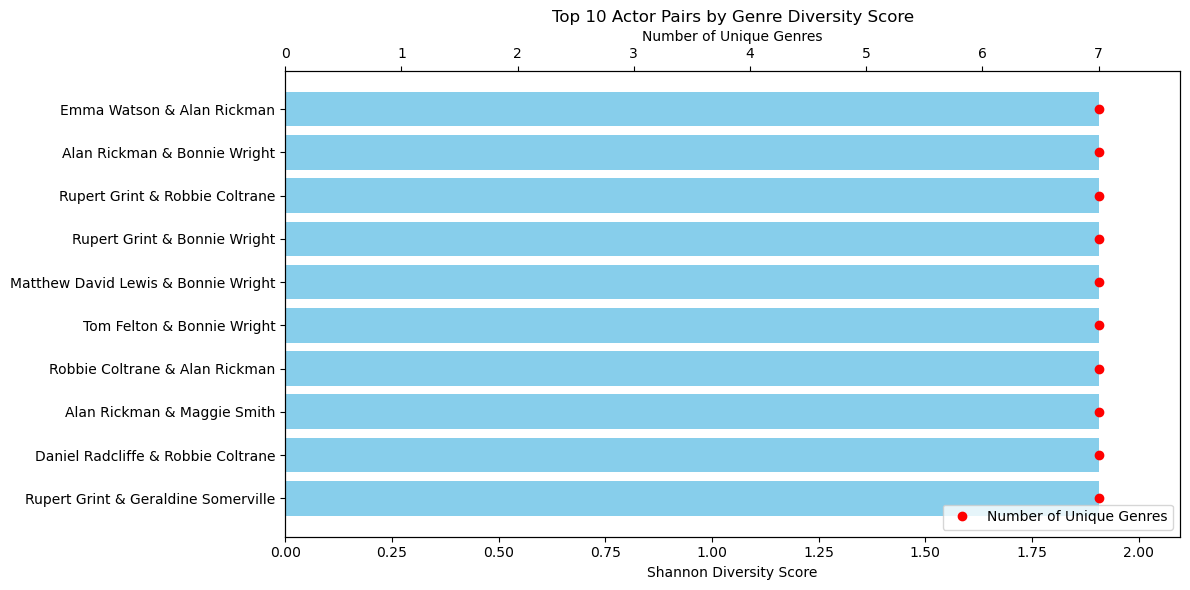

In [30]:
from src.helpers_actors_analysis import *

top_500_grossing_movies = filter_top_grossing_movies(merged_movie_character, top_n=500)

# Get the genres for these top movies and proceed with further analysis or visualization if needed
all_genres = top_500_grossing_movies['Movie genres'].dropna().str.split('|').sum()
genre_counts = Counter(all_genres)
top_50_genres = [genre for genre, count in genre_counts.most_common(50)]

# Filter the top 500 movies by top 50 genres if needed
filtered_top_movies = top_500_grossing_movies[top_500_grossing_movies['Movie genres'].apply(
    lambda genres: any(g in top_50_genres for g in genres.split('|')))]

actor_pair_genres = analyze_genre_preferences_by_actor_pairings(filtered_top_movies, top_n_pairs=500)
# Calculate diversity scores for the actor pairs
diversity_scores_df = calculate_genre_diversity(actor_pair_genres)

# Extract the top 10 actor pairs by diversity score
top_10_diversity_scores_df = diversity_scores_df.head(10)

# Plotting the Diversity Scores and Unique Genre Count for the Top 10 Actor Pairs
plt.figure(figsize=(12, 6))

# Plot Shannon Diversity Score as bars
ax1 = plt.gca()
ax1.barh(top_10_diversity_scores_df['Actor Pair'], top_10_diversity_scores_df['Shannon Diversity Score'], color='skyblue')
ax1.set_xlabel('Shannon Diversity Score')
ax1.set_title('Top 10 Actor Pairs by Genre Diversity Score')
ax1.invert_yaxis()  # Invert y-axis to have the highest score at the top
ax1.set_xlim([0, max(top_10_diversity_scores_df['Shannon Diversity Score']) * 1.1])

# Create a secondary axis for the unique genre count
ax2 = ax1.twiny()
ax2.plot(top_10_diversity_scores_df['Unique Genres'], top_10_diversity_scores_df['Actor Pair'], 'ro', label='Number of Unique Genres')
ax2.set_xlabel('Number of Unique Genres')
ax2.set_xlim([0, max(top_10_diversity_scores_df['Unique Genres']) * 1.1])
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()


the last one is still bugging